Found 49 images belonging to 3 classes.
Found 12 images belonging to 3 classes.
Epoch 1/50
13/13 [==============================] - 1s 32ms/step - loss: 1.4071 - accuracy: 0.3061 - val_loss: 1.0758 - val_accuracy: 0.3333
Epoch 2/50
13/13 [==============================] - 0s 24ms/step - loss: 1.0980 - accuracy: 0.3061 - val_loss: 1.0807 - val_accuracy: 0.3333
Epoch 3/50
13/13 [==============================] - 0s 25ms/step - loss: 1.0747 - accuracy: 0.3878 - val_loss: 1.0308 - val_accuracy: 0.3333
Epoch 4/50
13/13 [==============================] - 0s 24ms/step - loss: 1.0775 - accuracy: 0.3878 - val_loss: 1.1039 - val_accuracy: 0.3333
Epoch 5/50
13/13 [==============================] - 0s 26ms/step - loss: 1.0945 - accuracy: 0.3469 - val_loss: 1.0332 - val_accuracy: 0.5000
Epoch 6/50
13/13 [==============================] - 0s 27ms/step - loss: 1.0672 - accuracy: 0.3878 - val_loss: 0.9916 - val_accuracy: 0.5833
Epoch 7/50
13/13 [==============================] - 0s 27ms/step - loss: 1

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


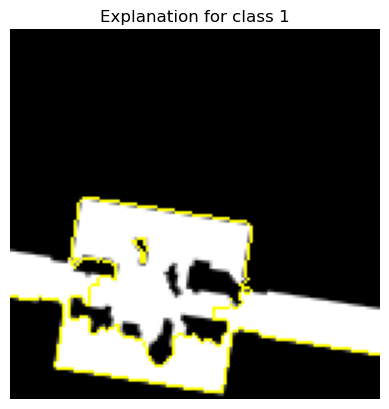

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Parameters
img_height, img_width = 128, 128  # Adjust based on your dataset
batch_size = 4
num_classes = 3
epochs = 50

# Path to the dataset
dataset_path = './Datasets/Phase Shifter'

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # Use 20% of data for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# Load the training data
train_generator = datagen.flow_from_directory(
    dataset_path,  # Path to the dataset
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


# Load the validation data
validation_generator = datagen.flow_from_directory(
    dataset_path,  # Path to the dataset
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Extract validation images and labels for LIME
val_images, val_labels = next(validation_generator)
val_images = val_images[:batch_size]  # Take a batch of images
val_labels = val_labels[:batch_size]

# would increasing the batch size help in tuning?? - read up

# Define the prediction function for LIME
def predict_fn(images):
    return model.predict(images)

# Use LIME to explain a sample image
explainer = lime_image.LimeImageExplainer()
idx = 0  # Index of the image to explain
explanation = explainer.explain_instance(val_images[idx], predict_fn, top_labels=num_classes, hide_color=0, num_samples=1000)

# Plot the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(val_images[idx], mask))
plt.title(f'Explanation for class {np.argmax(val_labels[idx])}')
plt.axis('off')
plt.show()


In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img

# Directory paths
dataset_path = './Datasets/Phase Shifter'
output_path = './Cropped_Dataset/Phase Shifter'
class_names = ['No-Shift', 'Pi-2-Shift', 'Pi-Shift']

# Ensure output directories exist
for class_name in class_names:
    os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

# Crop function
def crop_to_middle_square(image, crop_size=64):
    center = image.shape[0] // 2
    half_crop = crop_size // 2
    return image[center-half_crop:center+half_crop, center-half_crop:center+half_crop, :]

# Load, crop, and save images
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    output_class_path = os.path.join(output_path, class_name)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)
            img_array = img_to_array(img)
            cropped_img_array = crop_to_middle_square(img_array, 64)
            cropped_img = array_to_img(cropped_img_array)
            save_img(os.path.join(output_class_path, img_name), cropped_img)

print("Cropped images have been saved successfully.")


Cropped images have been saved successfully.


In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directory path for the No-Shift class
no_shift_path = './Datasets/Phase Shifter/No-Shift'

# List to store the images
images = []

# Load images from the No-Shift directory
for img_name in os.listdir(no_shift_path):
    if img_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
        img_path = os.path.join(no_shift_path, img_name)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert image to array
        images.append(img_array)  # Append image array to the list

# Convert the list of images to a NumPy array
images_array = np.array(images)

# Print the shape of the images array
print("Shape of the images array:", images_array.shape)


Shape of the images array: (21, 1250, 1250, 3)


In [31]:
import numpy as np

# Crop the image to the middle square region
def crop_to_middle_square(image, crop_size=64):
    center = image.shape[0] // 2
    half_crop = crop_size // 2
    return image[center-half_crop:center+half_crop, center-half_crop:center+half_crop, :]

# Crop all images in the dataset
cropped_images = np.array([crop_to_middle_square(img, 64) for img in images])